In [1]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
numpy.random.seed(1234)

In [4]:
from sklearn.datasets import make_blobs
n_dim = 2
x_tra, y_tra = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)
x_tes, y_tes = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1]], shuffle=True)
y_tra = (y_tra * 2) - 1
y_tes = (y_tes * 2) - 1

In [5]:
def svm(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return numpy.sign(y)

In [6]:
def svm_dist(y, x, w, avg=False, pre=False):
    y_ = svm(x, w, pre=True)
    if pre:
        return 1. - y_ * y
    d = numpy.maximum(0., 1. - y_ * y)
    
    if not avg:
        return d
    
    return numpy.sum(d) + numpy.sum(w**2)

In [7]:
def cost(w, x, y):
    return svm_dist(y, x, w, avg=True)

svm_rule = grad(cost)

In [8]:
def _svm_dist(w, x, y, avg=False):
    return svm_dist(y, x, w, avg=avg), svm_rule(w, x, y)

In [9]:
w0 = 1e-4 * npr.randn(n_dim+1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_svm_dist, w0, (x_tra, y_tra, True), 
                              method='L-BFGS-B', jac=True, options={'maxls': 100})

In [10]:
print res
w = res.x

      fun: 12.640584442419977
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.22684238, -0.15003265, -0.54921419])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 15
   status: 0
  success: True
        x: array([-1.48190888, -0.64995796,  0.22539291])


In [11]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == -1 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [12]:
def vis_hyperplane(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    m0, m1 = lim0[0], lim0[1]

    intercept0 = -(w[0] * m0 + w[-1])/w[1]
    intercept1 = -(w[0] * m1 + w[-1])/w[1]
    
    plt1, = plot.plot([m0, m1], [intercept0, intercept1], typ)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

In [13]:
def vis_sv(w):
    d = svm_dist(y_tra, x_tra, w, pre=True)
    
    plot.hold('on')
    
    for dd, xx in zip(d, x_tra):
        if dd >= 0.:
            plot.plot(xx[0], xx[1], '*')
    
    plot.hold('off')

<IPython.core.display.Javascript object>


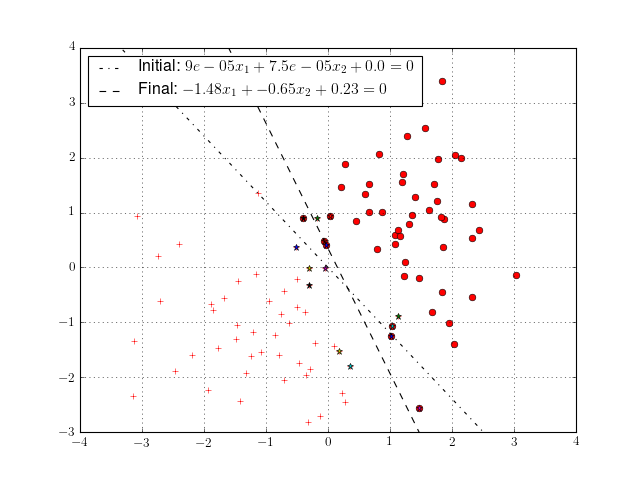

In [14]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
#vis_data(x_tes, y_tes, c='b')
vis_sv(w)

plt0 = vis_hyperplane(w0, 'k-.')
plt1 = vis_hyperplane(w, 'k--')
plot.legend([plt0, plt1], [
        'Initial: ${:.2} x_1 + {:.2} x_2 + {:.2} = 0$'.format(*list(w0)),
        'Final: ${:.2f} x_1 + {:.2f} x_2 + {:.2f} = 0$'.format(*list(w))],
           loc='best')

plot.show()

In [15]:
tra_er = numpy.sum(numpy.abs(svm(x_tra, w) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(svm(x_tes, w) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.08, Test error rate 0.28
